# FIFA World Cup 2026 – Poisson Model & Monte Carlo Simulation

This notebook analyses a full-tournament prediction model for the 2026 FIFA World Cup, based on:

- Match data from international fixtures (2018–2025)
- A Poisson regression model estimating team attack/defence strength and home advantage
- Monte Carlo simulations of:
  - The group stage (match-by-match Poisson score sampling)
  - A 32-team knockout bracket (Round of 32 → Final)

**Key outputs:**

- Group-stage expectations (points, qualification odds, finishing positions)
- Knockout progression probabilities (R16, QF, SF, Final, Champion)
- Visualisations and short interpretations for portfolio / GitHub / LinkedIn.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:0.4f}")

PROJECT_ROOT = "/Users/Ole_Kruse/Desktop/coding_project"
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")


PROJECT_ROOT, DATA_PROCESSED_DIR


('/Users/Ole_Kruse/Desktop/coding_project',
 '/Users/Ole_Kruse/Desktop/coding_project/data/processed')

In [2]:
# Group-stage match-level probabilities
group_match_probs_path = os.path.join(
    DATA_PROCESSED_DIR, "wc2026_group_stage_match_probs.csv"
)
group_match_probs = pd.read_csv(group_match_probs_path, parse_dates=["date"])

# Full-tournament simulation summary (group + knockout)
full_tournament_path = os.path.join(
    DATA_PROCESSED_DIR, "wc2026_full_tournament_simulation_summary.csv"
)
tournament_summary = pd.read_csv(full_tournament_path)

group_match_probs.head(), tournament_summary.head()


(        date group      home_team     away_team  lambda_home  lambda_away  \
 0 2026-06-11     A         Mexico  South Africa       1.0773       0.6939   
 1 2026-06-11     A    South Korea       Denmark       0.6947       1.4559   
 2 2026-06-12     B         Canada         Italy       0.7559       1.3558   
 3 2026-06-12     D  United States      Paraguay       1.0179       0.8571   
 4 2026-06-13     C          Haiti      Scotland       0.8035       1.9068   
 
    p_home_win  p_draw  p_away_win  
 0      0.4431  0.3231      0.2338  
 1      0.1780  0.2675      0.5545  
 2      0.2086  0.2807      0.5106  
 3      0.3835  0.3193      0.2972  
 4      0.1512  0.2148      0.6340  ,
         team group  exp_points  exp_gd  exp_gf  prob_1st  prob_2nd  prob_3rd  \
 0     Brazil     C      7.1574  5.5222  6.8905    0.7423    0.2082    0.0450   
 1      Spain     H      6.9762  4.6673  6.2500    0.6891    0.2634    0.0391   
 2    England     L      6.9899  4.5885  6.2457    0.6974    0.2

## 1. Data overview

We first inspect the two main outputs:

1. `wc2026_group_stage_match_probs.csv`
   - One row per group-stage match
   - Expected goals for each team (`lambda_home`, `lambda_away`)
   - Win/draw/loss probabilities (`p_home_win`, `p_draw`, `p_away_win`)

2. `wc2026_full_tournament_simulation_summary.csv`
   - One row per team
   - Group-stage expectations (points, goal difference, goals scored, position probabilities)
   - Knockout probabilities (reaching R32, R16, QF, SF, Final, Champion)


In [3]:
print("Group match probabilities:")
display(group_match_probs.describe())

print("\nFull tournament summary:")
display(tournament_summary.describe())

print("\nColumns in tournament_summary:")
print(tournament_summary.columns.tolist())


Group match probabilities:


,date,lambda_home,lambda_away,p_home_win,p_draw,p_away_win
count,72,72.0000,72.0000,72.0000,72.0000,72.0000
mean,2026-06-20 03:20:00,1.2994,1.0567,0.4247,0.2413,0.3340
min,2026-06-11 00:00:00,0.3668,0.3540,0.0343,0.0516,0.0138
25%,2026-06-16 00:00:00,0.7684,0.6506,0.2080,0.1913,0.1564
50%,2026-06-20 12:00:00,1.1454,0.9625,0.3826,0.2579,0.3187
75%,2026-06-24 06:00:00,1.6093,1.3013,0.5891,0.2938,0.4979
max,2026-06-27 00:00:00,3.6269,2.6954,0.9346,0.3528,0.8533
std,NaN,0.7111,0.5700,0.2477,0.0715,0.2301



Full tournament summary:


,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual,prob_R16,prob_QF,prob_SF,prob_F,prob_W
count,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000
mean,4.1386,-0.0000,3.5348,0.2500,0.2500,0.2500,0.2500,0.6667,0.1667,0.0833,0.0417,0.0208,0.0208
std,1.7655,2.9660,1.5243,0.2241,0.1265,0.1271,0.2482,0.2841,0.0787,0.0551,0.0365,0.0234,0.0328
min,1.0594,-5.9250,1.2711,0.0040,0.0270,0.0391,0.0045,0.0912,0.0119,0.0018,0.0000,0.0000,0.0000
25%,2.7704,-1.7537,2.3347,0.0558,0.1803,0.1454,0.0481,0.4731,0.1052,0.0317,0.0089,0.0023,0.0006
50%,4.1440,0.0369,3.3224,0.1859,0.2588,0.2482,0.1767,0.7289,0.1908,0.0770,0.0311,0.0113,0.0054
75%,5.4756,2.0689,4.5456,0.3960,0.3257,0.3219,0.3492,0.9050,0.2309,0.1399,0.0743,0.0330,0.0263
max,7.1574,5.5222,6.8905,0.7423,0.5402,0.5818,0.8358,0.9921,0.2615,0.1729,0.1140,0.0806,0.1337



Columns in tournament_summary:
['team', 'group', 'exp_points', 'exp_gd', 'exp_gf', 'prob_1st', 'prob_2nd', 'prob_3rd', 'prob_4th', 'prob_qual', 'prob_R16', 'prob_QF', 'prob_SF', 'prob_F', 'prob_W']


## 2. Tournament favourites – Win probabilities

We start with a simple ranking of teams by the probability of winning the World Cup (`prob_W`).

This gives a clear picture of which teams the model considers top contenders and how concentrated the title chances are.


,team,group,prob_W,prob_F,prob_SF,prob_QF
0,Brazil,C,0.1337,0.0806,0.1140,0.1631
1,Spain,H,0.1129,0.0754,0.1101,0.1729
2,England,L,0.0997,0.0670,0.1126,0.1651
3,Argentina,J,0.0953,0.0729,0.1089,0.1553
4,Portugal,K,0.0711,0.0631,0.0973,0.1590
5,France,I,0.0676,0.0614,0.1035,0.1549
6,Colombia,K,0.0530,0.0496,0.0906,0.1566
7,Belgium,G,0.0499,0.0532,0.0975,0.1602
8,Netherlands,F,0.0429,0.0432,0.0799,0.1454
9,Denmark,A,0.0313,0.0372,0.0751,0.1433


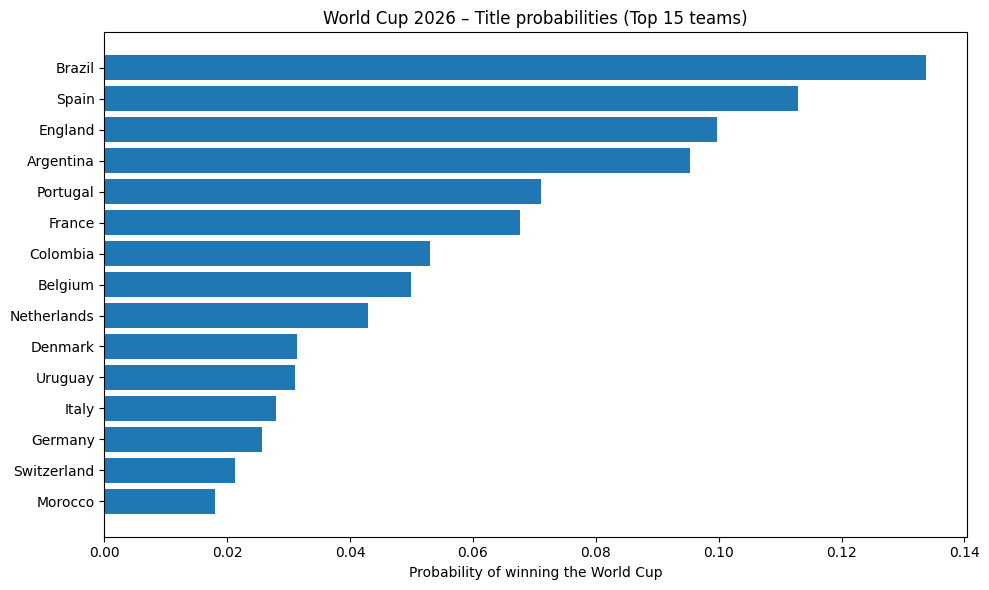

In [4]:
# Sort teams by probability of winning the World Cup
favorites = tournament_summary.sort_values("prob_W", ascending=False).reset_index(drop=True)

# Take top 15 for a compact view
top_n = 15
favorites_top = favorites.head(top_n)

display(favorites_top[["team", "group", "prob_W", "prob_F", "prob_SF", "prob_QF"]])

# Bar plot of winner probabilities
plt.figure(figsize=(10, 6))
plt.barh(favorites_top["team"][::-1], favorites_top["prob_W"][::-1])
plt.xlabel("Probability of winning the World Cup")
plt.title("World Cup 2026 – Title probabilities (Top 15 teams)")
plt.tight_layout()
plt.show()


### Interpretation

Some points you might mention in your README / LinkedIn post:

- **Top tier:** Brazil, Spain, England, Argentina form the leading cluster with roughly 9–13% title probability each.
- **Next tier:** Portugal, France, Colombia, Belgium sit just below, reflecting strong recent performance but a slightly tougher path.
- **Dark horses:** Netherlands, Denmark, Uruguay, Croatia, Germany and Italy still have non-trivial paths to the trophy, but require multiple favourable results in high-variance knockout matches.
- The model reflects **realistic parity** at the very top: no team has an absurdly high (>30%) title probability, because the knockout bracket is random and strong teams can meet early.


## 3. Group-by-group qualification and finishing probabilities

For each group (A–L), we visualise:

- Probability of finishing **1st**, **2nd**, **3rd**, **4th**
- Probability of **qualifying for the knockout phase** (`prob_qual` – reaching the Round of 32)

This illustrates:
- Which groups are “groups of death”
- Which teams are overwhelming favourites vs balanced groups


In [5]:
def plot_group_overview(group_id: str, df: pd.DataFrame):
    """
    Plot finishing position & qualification probabilities for one group.
    """
    group_df = df[df["group"] == group_id].copy()
    group_df = group_df.sort_values("prob_1st", ascending=False)

    display(group_df[[
        "team", "exp_points", "exp_gd", "exp_gf",
        "prob_1st", "prob_2nd", "prob_3rd", "prob_4th", "prob_qual"
    ]])

    teams = group_df["team"]

    # Stacked bar for positions
    pos_matrix = group_df[["prob_1st", "prob_2nd", "prob_3rd", "prob_4th"]].values

    plt.figure(figsize=(10, 5))
    bottom = np.zeros(len(teams))
    labels = ["1st", "2nd", "3rd", "4th"]
    for i, label in enumerate(labels):
        plt.bar(teams, pos_matrix[:, i], bottom=bottom, label=label)
        bottom += pos_matrix[:, i]

    plt.ylabel("Probability")
    plt.title(f"Group {group_id} – Finishing position probabilities")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Position")
    plt.tight_layout()
    plt.show()

    # Qualification probability
    plt.figure(figsize=(8, 4))
    plt.bar(teams, group_df["prob_qual"])
    plt.ylabel("Probability of reaching Round of 32")
    plt.title(f"Group {group_id} – Qualification probabilities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [6]:
all_groups = sorted(tournament_summary["group"].unique())
all_groups


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


=== Group A ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
9,Denmark,5.8214,2.2936,4.1908,0.5417,0.2585,0.1398,0.0600,0.9163
29,Mexico,3.9925,-0.0818,2.9235,0.2081,0.2916,0.2730,0.2273,0.6988
33,South Korea,3.6305,-0.5961,2.7336,0.1680,0.2662,0.2905,0.2753,0.6323
35,South Africa,2.7803,-1.6157,1.9233,0.0822,0.1837,0.2967,0.4374,0.4529


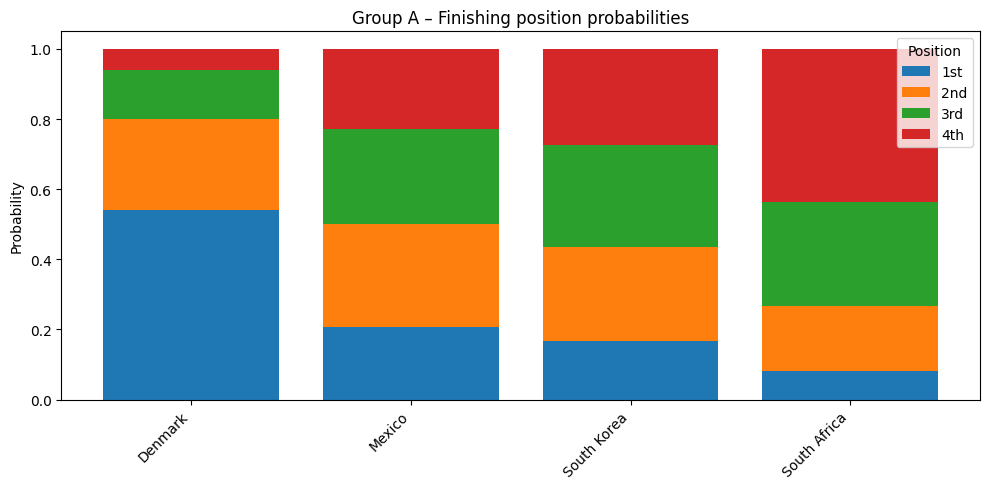

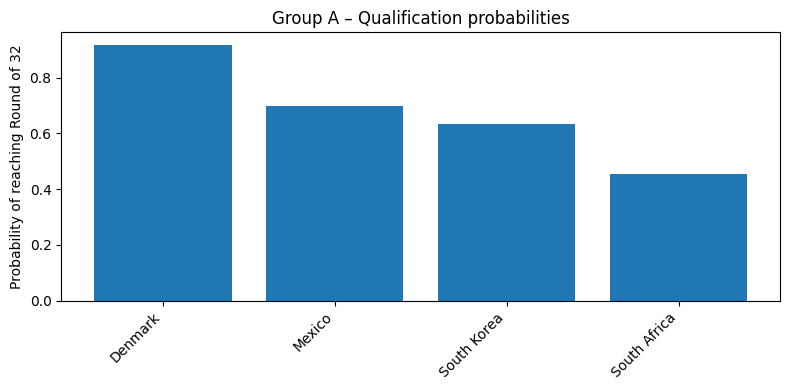


=== Group B ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
11,Italy,5.7150,2.4479,4.8895,0.4494,0.3251,0.1799,0.0456,0.9247
13,Switzerland,5.4031,2.0640,4.8507,0.3875,0.3462,0.2071,0.0592,0.9012
26,Canada,3.8734,-0.2482,3.3523,0.1433,0.2606,0.4089,0.1872,0.7042
42,Qatar,1.6201,-4.2637,2.2043,0.0198,0.0681,0.2041,0.7080,0.2073


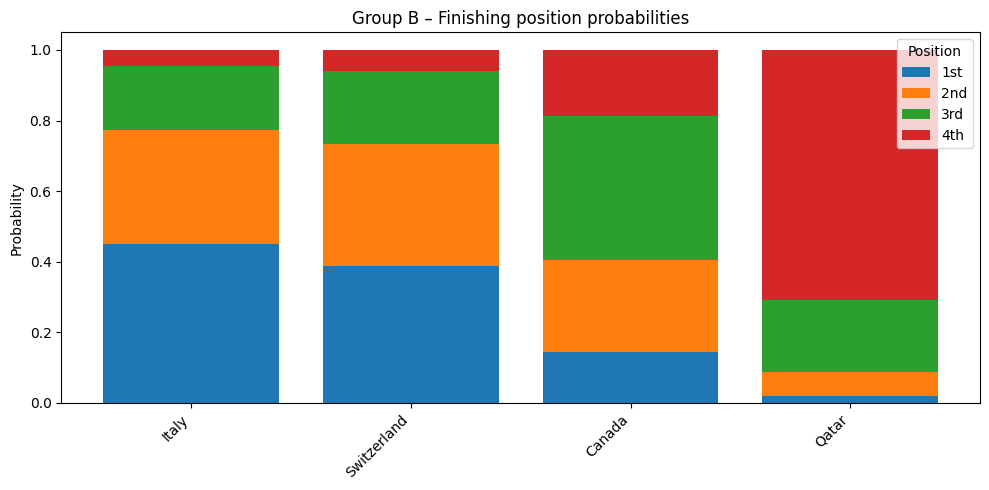

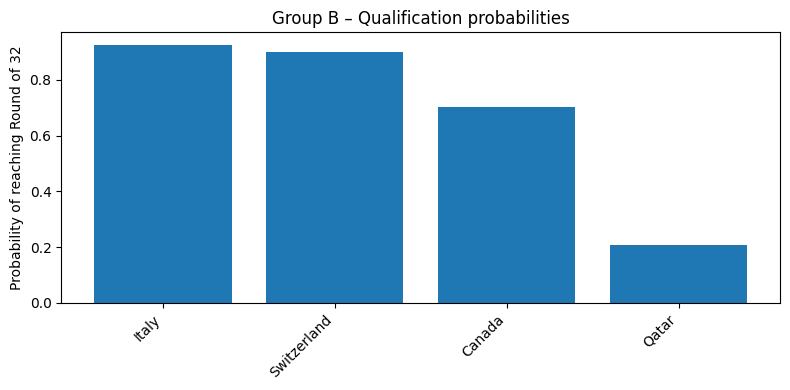


=== Group C ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
0,Brazil,7.1574,5.5222,6.8905,0.7423,0.2082,0.0450,0.0045,0.9921
14,Morocco,5.0331,1.4579,3.6994,0.1928,0.5133,0.2483,0.0456,0.8980
34,Scotland,3.4046,-1.0551,3.0121,0.0609,0.2408,0.5307,0.1676,0.6511
45,Haiti,1.1679,-5.9250,1.6033,0.0040,0.0377,0.1760,0.7823,0.1190


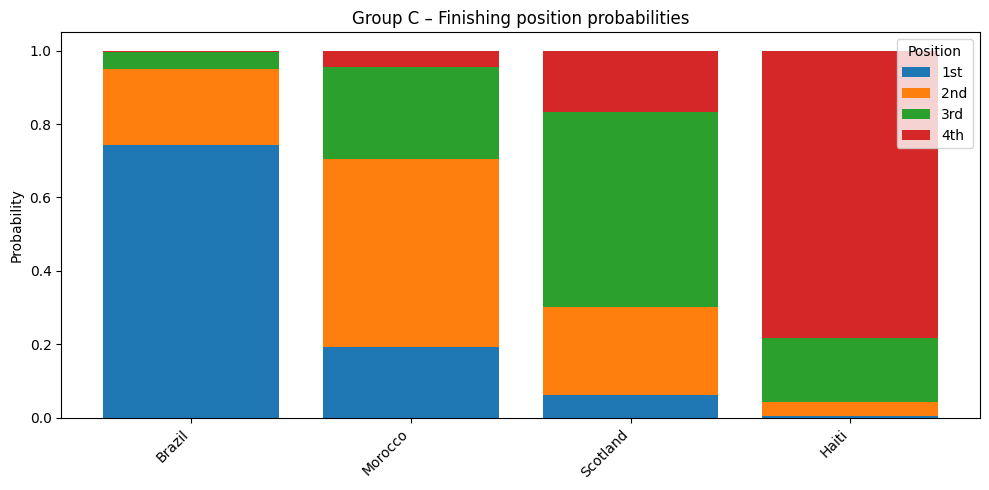

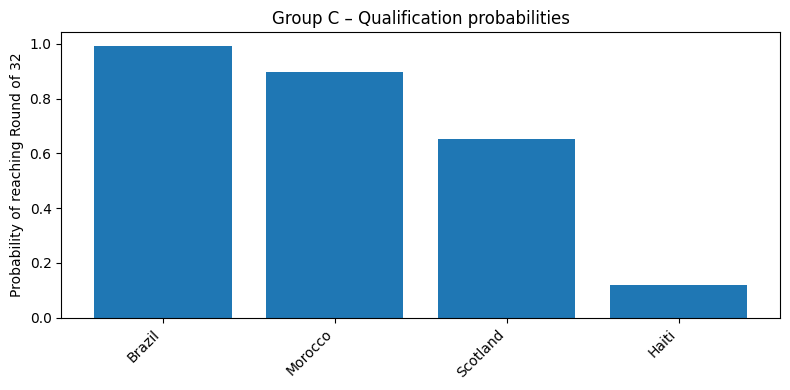


=== Group D ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
23,Australia,4.3863,0.4343,3.2841,0.2920,0.2660,0.2380,0.2040,0.7399
25,United States,4.2058,0.2258,3.3419,0.2821,0.2590,0.2373,0.2216,0.7180
30,Turkey,3.8987,-0.2526,3.4183,0.2363,0.2353,0.2482,0.2802,0.6587
31,Paraguay,3.6949,-0.4075,2.6842,0.1896,0.2397,0.2765,0.2942,0.6304


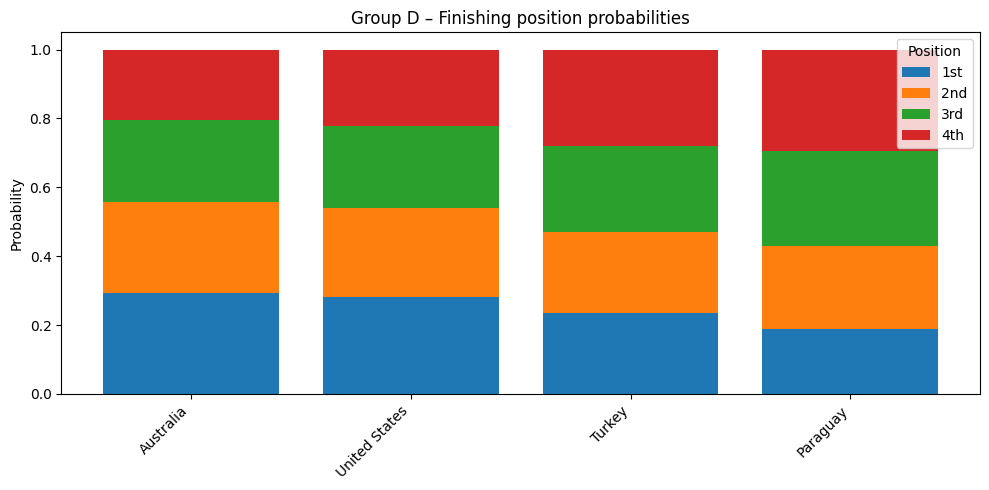

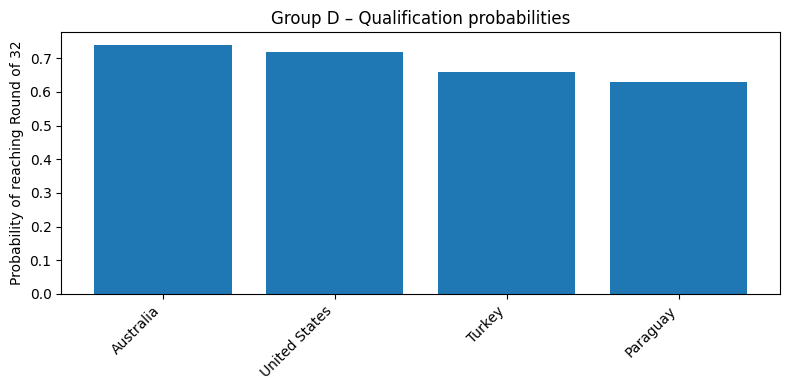


=== Group E ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
12,Germany,6.1964,3.7935,6.1331,0.5495,0.2885,0.1456,0.0164,0.9700
16,Ecuador,5.2171,1.6870,3.9816,0.2946,0.3830,0.2735,0.0489,0.8943
27,Ivory Coast,4.1741,0.1720,3.2953,0.1515,0.3015,0.4481,0.0989,0.7781
47,Curaçao,1.0594,-5.6525,1.3733,0.0044,0.0270,0.1328,0.8358,0.0912


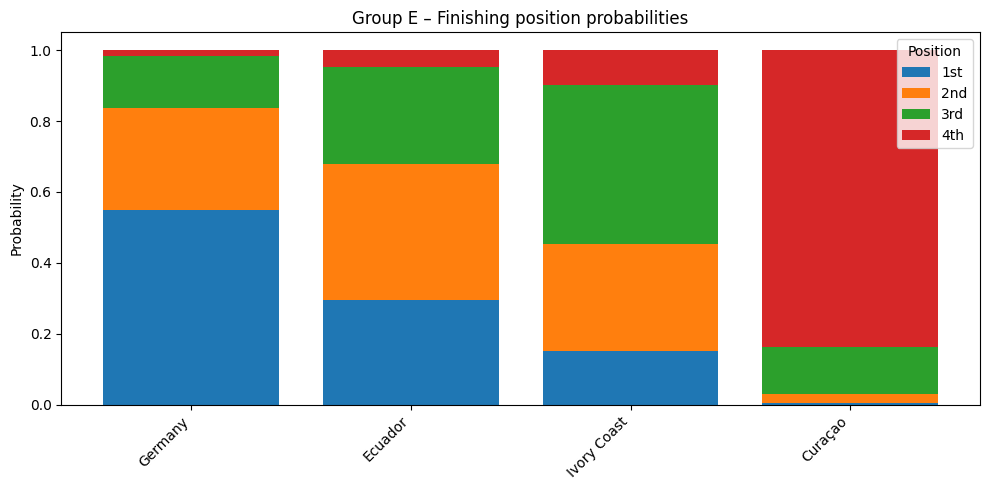

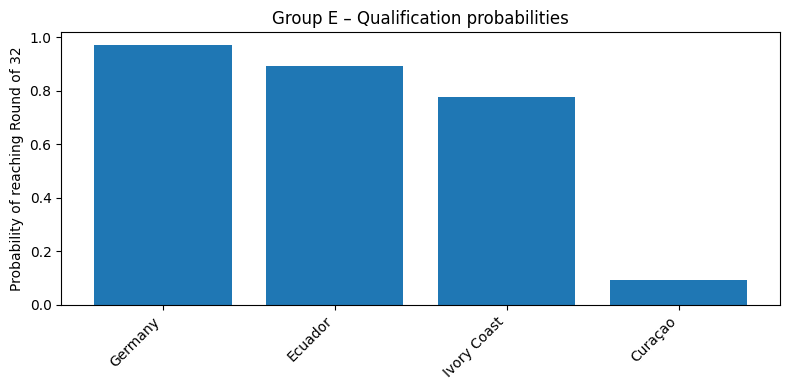


=== Group F ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
8,Netherlands,5.5906,2.0836,4.7069,0.5084,0.2627,0.1448,0.0841,0.8891
20,Japan,4.0539,-0.1088,3.4279,0.2174,0.2792,0.2711,0.2323,0.6951
24,Tunisia,3.4791,-0.6971,2.5127,0.1451,0.2466,0.3013,0.3070,0.5913
32,Poland,3.2118,-1.2777,2.8517,0.1291,0.2115,0.2828,0.3766,0.5361


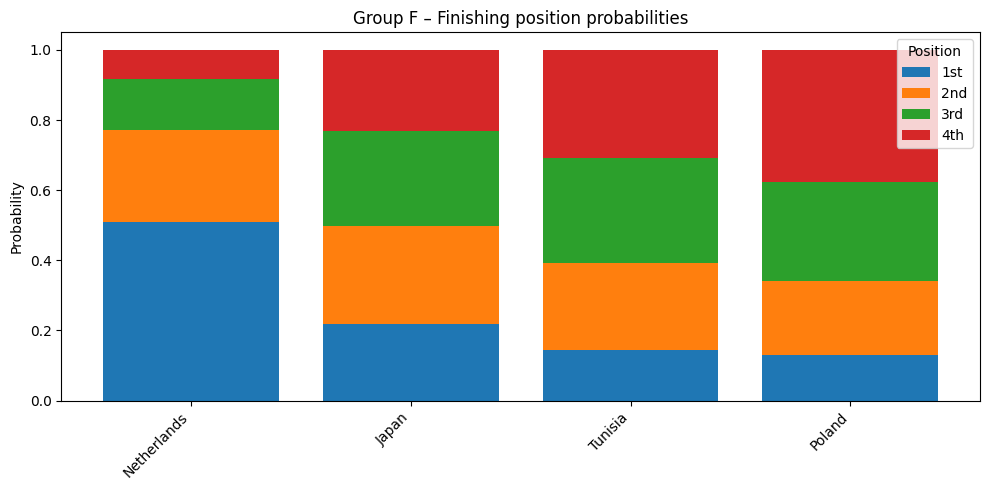

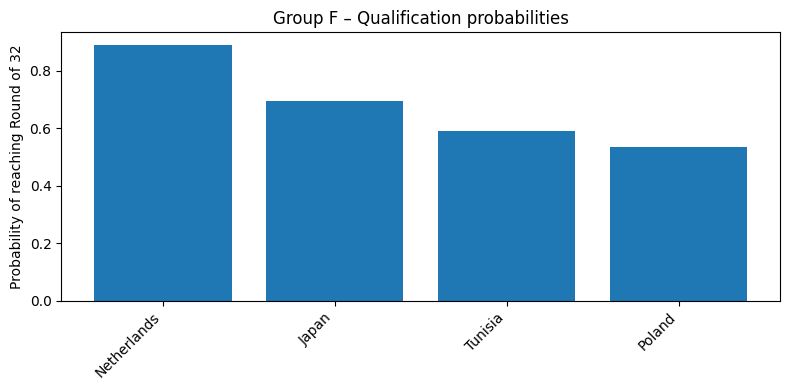


=== Group G ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
7,Belgium,6.5253,3.4945,5.2097,0.6588,0.2297,0.0890,0.0225,0.9652
22,Iran,4.1788,0.0501,2.8592,0.1811,0.3560,0.3199,0.1430,0.7530
28,Egypt,3.8822,-0.2860,2.5464,0.1398,0.3211,0.3533,0.1858,0.6912
41,New Zealand,1.7747,-3.2586,1.2711,0.0203,0.0932,0.2378,0.6487,0.2276


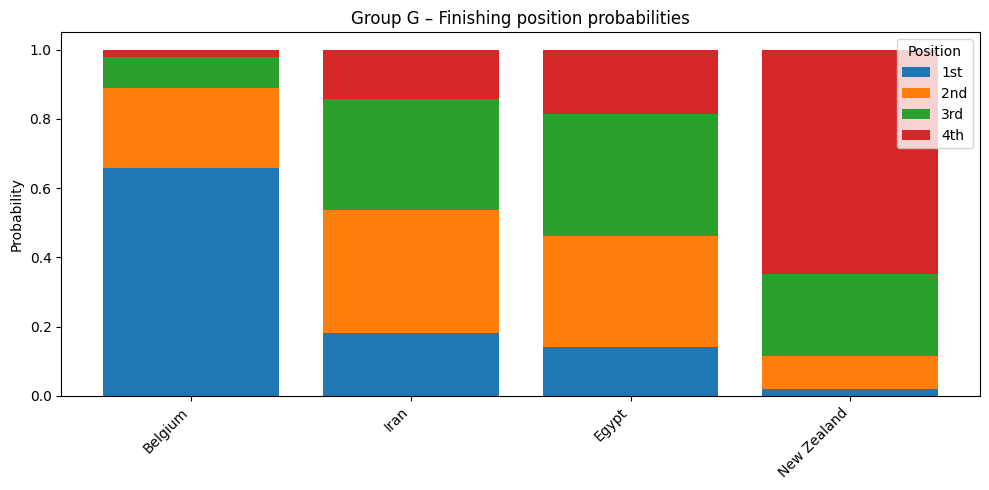

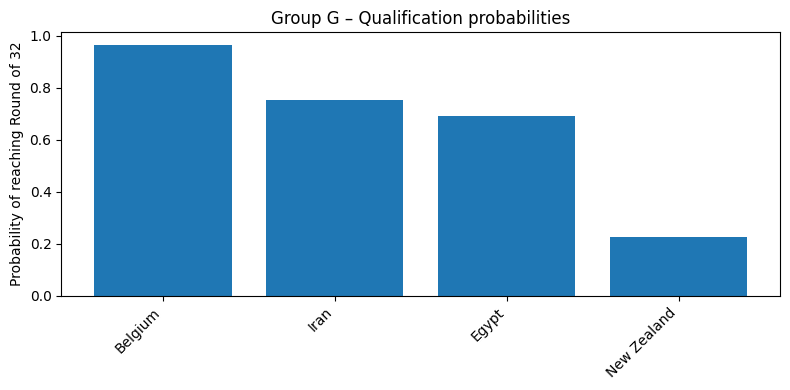


=== Group H ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
1,Spain,6.9762,4.6673,6.2500,0.6891,0.2634,0.0391,0.0084,0.9852
10,Uruguay,5.4372,1.8510,3.9810,0.2795,0.5402,0.1420,0.0383,0.9202
40,Cape Verde,2.0826,-3.3872,1.6413,0.0159,0.0929,0.3984,0.4928,0.2935
38,Saudi Arabia,2.1161,-3.1311,1.5981,0.0155,0.1035,0.4205,0.4605,0.3101


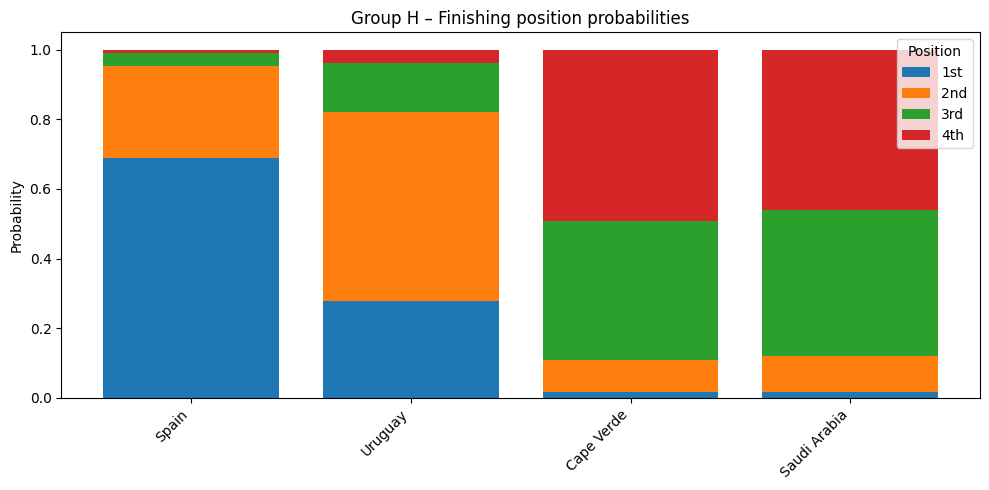

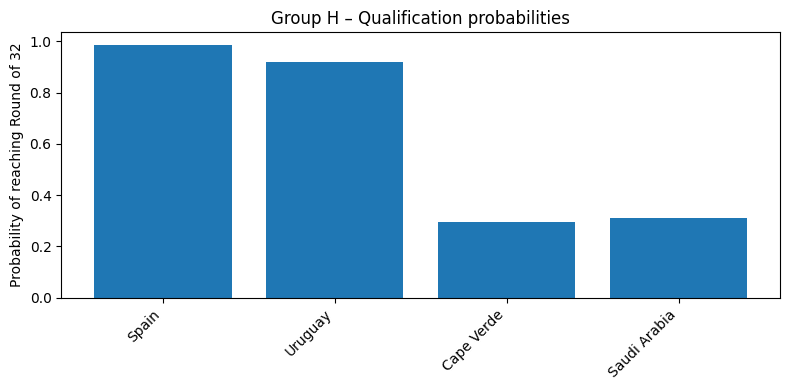


=== Group I ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
5,France,6.4095,3.5837,5.6975,0.6110,0.2520,0.1134,0.0236,0.9614
18,Norway,4.4444,0.5927,4.0823,0.2039,0.3476,0.3279,0.1206,0.7981
19,Senegal,4.2149,0.2227,3.3029,0.1677,0.3351,0.3645,0.1327,0.7671
39,Bolivia,1.5543,-4.3991,2.0055,0.0174,0.0653,0.1942,0.7231,0.1931


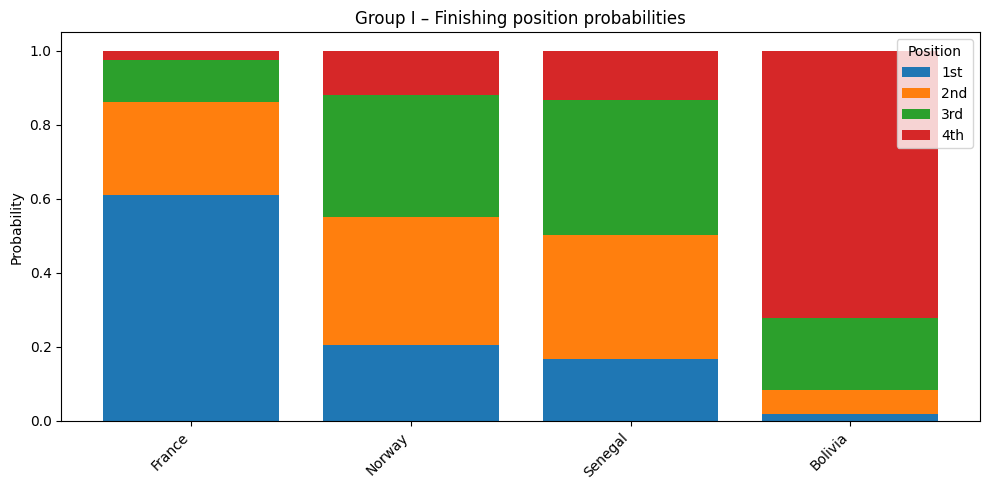

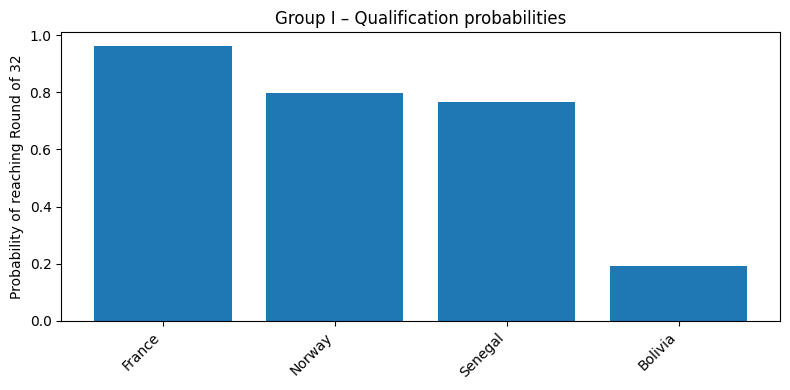


=== Group J ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
3,Argentina,6.7885,4.1966,5.9084,0.6729,0.2327,0.0816,0.0128,0.9770
17,Austria,4.5070,0.6530,4.0035,0.1821,0.3877,0.3316,0.0986,0.8165
21,Algeria,4.1139,0.0238,3.8286,0.1367,0.3277,0.3983,0.1373,0.7560
44,Jordan,1.3278,-4.8734,1.7401,0.0083,0.0519,0.1885,0.7513,0.1550


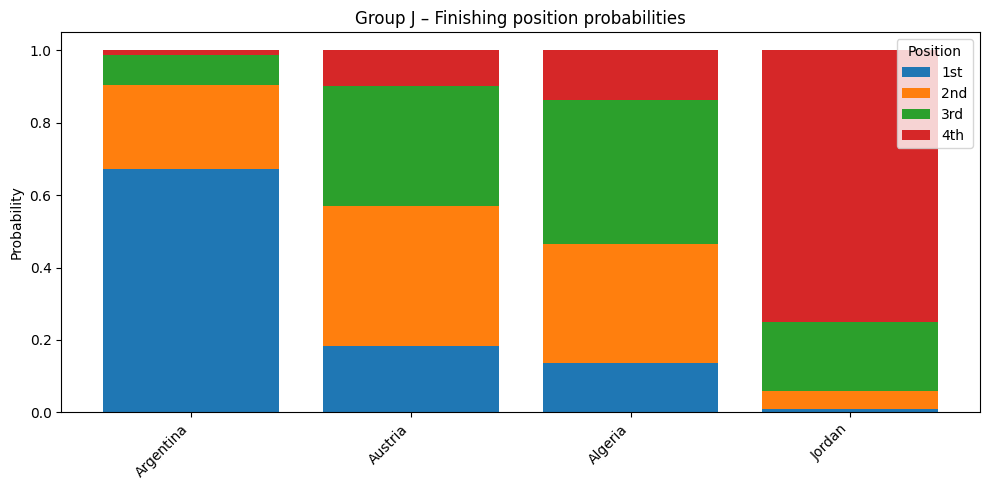

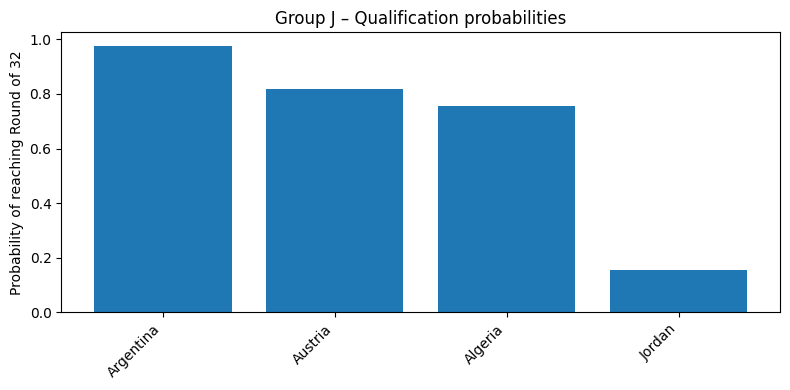


=== Group K ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
4,Portugal,6.5593,4.2909,6.2832,0.5452,0.3737,0.0719,0.0092,0.9803
6,Colombia,6.2266,3.3234,5.2875,0.4216,0.4663,0.0974,0.0147,0.9670
37,Uzbekistan,2.7409,-2.2442,2.3061,0.0288,0.1289,0.5818,0.2605,0.4767
46,Jamaica,1.2919,-5.3701,1.5130,0.0044,0.0311,0.2489,0.7156,0.1336


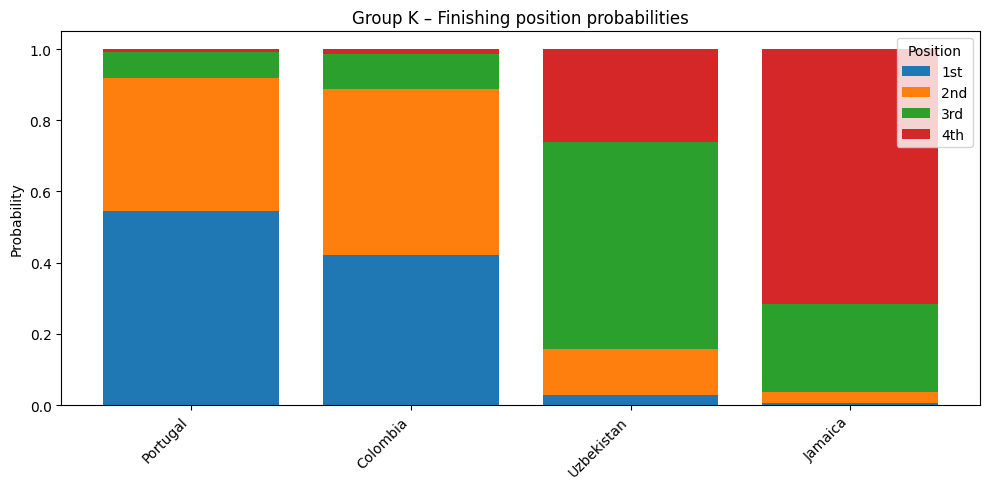

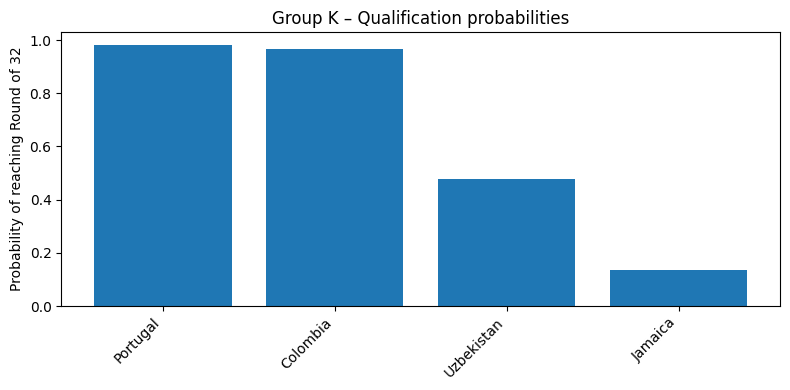


=== Group L ===


,team,exp_points,exp_gd,exp_gf,prob_1st,prob_2nd,prob_3rd,prob_4th,prob_qual
2,England,6.9899,4.5885,6.2457,0.6974,0.2410,0.0521,0.0095,0.9834
15,Croatia,5.1770,1.6127,4.4918,0.2452,0.5003,0.1900,0.0645,0.8841
36,Ghana,2.7207,-2.1678,2.3442,0.0406,0.1702,0.4491,0.3401,0.4623
43,Panama,1.8452,-4.0334,1.9913,0.0168,0.0885,0.3088,0.5859,0.2523


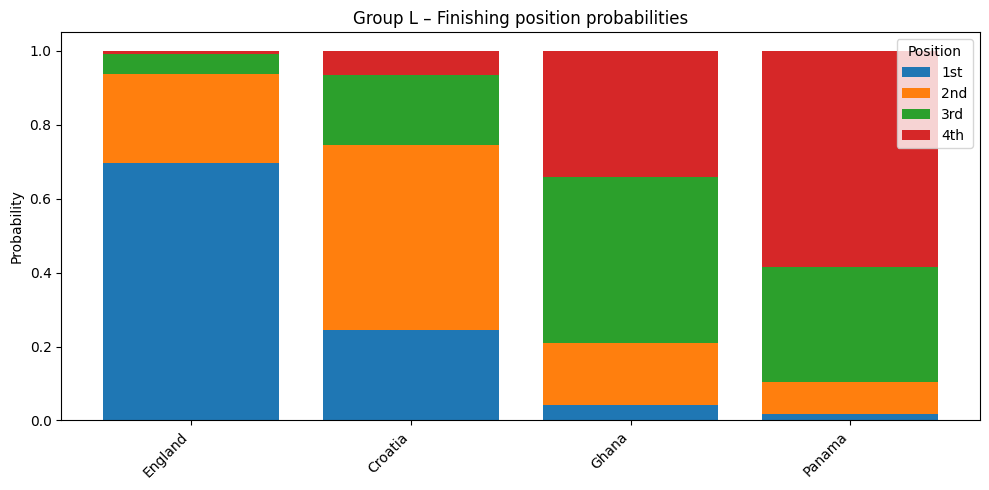

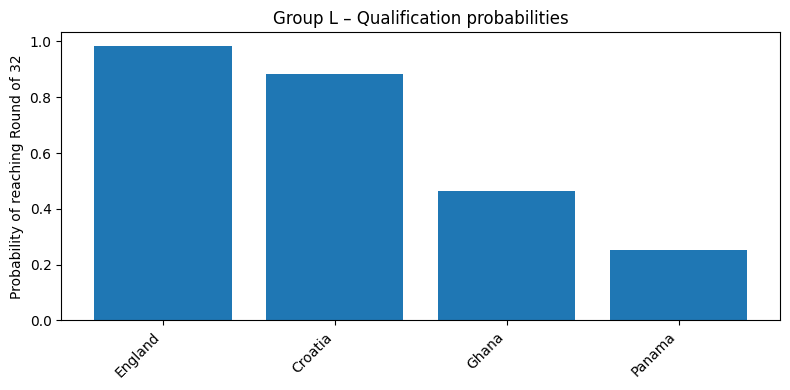

In [7]:
for g in all_groups:
    print(f"\n=== Group {g} ===")
    plot_group_overview(g, tournament_summary)


## 4. Deep-run probabilities (SF, Final, Champion)

Next we focus on the probability that teams reach:

- At least the **Quarterfinals** (`prob_QF`)
- At least the **Semifinals** (`prob_SF`)
- The **Final** (`prob_F`)
- Win the **World Cup** (`prob_W`)

This highlights not only favourites to win, but also teams that are likely to make a deep run.


,team,group,prob_QF,prob_SF,prob_F,prob_W
0,Brazil,C,0.1631,0.1140,0.0806,0.1337
1,England,L,0.1651,0.1126,0.0670,0.0997
2,Spain,H,0.1729,0.1101,0.0754,0.1129
3,Argentina,J,0.1553,0.1089,0.0729,0.0953
4,France,I,0.1549,0.1035,0.0614,0.0676
5,Belgium,G,0.1602,0.0975,0.0532,0.0499
6,Portugal,K,0.1590,0.0973,0.0631,0.0711
7,Colombia,K,0.1566,0.0906,0.0496,0.0530
8,Netherlands,F,0.1454,0.0799,0.0432,0.0429
9,Italy,B,0.1405,0.0773,0.0375,0.0279


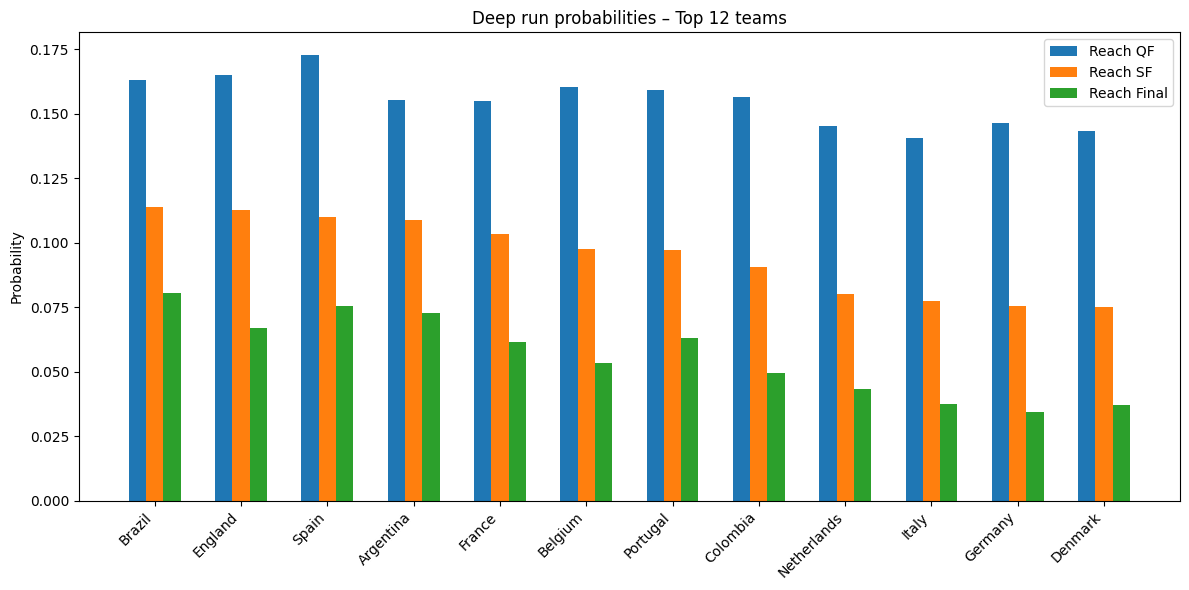

In [8]:
# Select relevant columns
deep_run = tournament_summary[[
    "team", "group", "prob_QF", "prob_SF", "prob_F", "prob_W"
]].copy()

# Sort by probability of reaching semi-finals as a proxy for deep run strength
deep_run_sorted = deep_run.sort_values("prob_SF", ascending=False).reset_index(drop=True)

display(deep_run_sorted.head(20))

# Stacked-ish bar chart for a subset (top 10–12 teams)
top_deep = deep_run_sorted.head(12)

x = np.arange(len(top_deep))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, top_deep["prob_QF"], width, label="Reach QF")
plt.bar(x,         top_deep["prob_SF"], width, label="Reach SF")
plt.bar(x + width, top_deep["prob_F"],  width, label="Reach Final")

plt.xticks(x, top_deep["team"], rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("Deep run probabilities – Top 12 teams")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Match-level examples – Upsets & balanced fixtures

The Poisson model also gives **match-level** probabilities for each group-stage game:

- Expected goals per team (`lambda_home`, `lambda_away`)
- Win/draw/loss probabilities (`p_home_win`, `p_draw`, `p_away_win`)

We can use this to:
- Identify potential **upsets**
- Highlight the most **balanced fixtures**


In [9]:
# Copy with helper columns
m = group_match_probs.copy()
m["favoured_team"] = np.where(
    m["p_home_win"] > m["p_away_win"],
    m["home_team"],
    m["away_team"],
)
m["favoured_prob"] = m[["p_home_win", "p_away_win"]].max(axis=1)

# Potential upsets: favoured_prob not too high (say < 0.6)
possible_upsets = m.sort_values("favoured_prob").head(10)

print("Most balanced / potential upset matches:")
display(possible_upsets[[
    "date", "group", "home_team", "away_team",
    "lambda_home", "lambda_away",
    "p_home_win", "p_draw", "p_away_win",
    "favoured_team", "favoured_prob"
]])


Most balanced / potential upset matches:


,date,group,home_team,away_team,lambda_home,lambda_away,p_home_win,p_draw,p_away_win,favoured_team,favoured_prob
64,2026-06-26,H,Cape Verde,Saudi Arabia,0.7937,0.8099,0.3190,0.3528,0.3282,Saudi Arabia,0.3282
62,2026-06-26,G,Egypt,Iran,0.8025,0.8754,0.3081,0.3429,0.3490,Iran,0.3490
11,2026-06-14,F,Poland,Tunisia,0.8831,0.9610,0.3171,0.3237,0.3592,Tunisia,0.3592
31,2026-06-19,D,United States,Australia,0.9876,1.0376,0.3340,0.3060,0.3600,Australia,0.3600
40,2026-06-22,I,Norway,Senegal,1.0703,1.0071,0.3656,0.3013,0.3331,Norway,0.3656
30,2026-06-19,D,Turkey,Paraguay,1.1223,1.0467,0.3724,0.2935,0.3341,Turkey,0.3724
70,2026-06-27,K,Colombia,Portugal,1.0282,1.1102,0.3311,0.2960,0.3729,Portugal,0.3729
27,2026-06-18,A,Mexico,South Korea,1.1141,0.9939,0.3817,0.2981,0.3201,Mexico,0.3817
35,2026-06-20,F,Tunisia,Japan,0.8541,1.0118,0.2974,0.3203,0.3823,Japan,0.3823
3,2026-06-12,D,United States,Paraguay,1.0179,0.8571,0.3835,0.3193,0.2972,United States,0.3835


## 6. Limitations & Modelling Choices

Some important caveats and modelling choices to note (for your README):

- **Data window:** Only matches from 2018–2025 are used, which reflects recent form but may overweight short-term trends.
- **Team-level model:** The Poisson model uses team-level attack/defence parameters and a global home advantage. It does not model:
  - Injuries
  - Squad rotation
  - Individual player strengths
- **Poisson assumptions:**
  - Goals are modelled as independent Poisson random variables for home and away teams.
  - This ignores tactical “game state” effects (e.g. teams shutting down at 1–0).
- **Knockout structure:**
  - A simplified 32-team bracket is used with random seeding of qualified teams.
  - Official FIFA 2026 third-place rules and fixed bracket positions are not replicated exactly (by design, to keep the project understandable and reproducible).
- **No betting odds or Elo ratings:**
  - The model is entirely driven by fixture outcomes and goal counts in international matches.
  - You can mention that this is a “purely data-driven Poisson model” without market information.

Despite these limitations, the pipeline is:
- fully reproducible,
- conceptually transparent, and
- strong enough for a GitHub portfolio project.


## 7. Possible Extensions

If you want to extend the project further:

1. **More realistic knockout bracket**
   - Implement the official FIFA 2026 structure with:
     - Fixed positions for group winners/runners-up
     - Correct mapping of third-place teams

2. **Time-decayed weights**
   - Give more weight to recent matches (e.g. exponential decay based on match date).

3. **Home/continent effects**
   - Add extra advantage for host confederation teams (USA, Mexico, Canada or CONCACAF).

4. **Interactive dashboard**
   - Build a Streamlit or Plotly Dash app that lets users:
     - Adjust number of simulations
     - Inspect probabilities by team or group
     - Explore hypothetical changes (e.g. injuries, form shocks)

5. **Comparison with betting odds**
   - Collect bookmaker implied probabilities before the tournament and compare:
     - Which teams the model over/underestimates relative to the market.
